In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
#from  pandasgui import show
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import cross_val_predict
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
train_data = pd.read_csv('../airline_passenger_satisfaction.csv')
print(train_data.info())
primeros_100_registros = train_data.iloc[:100]
test_data = pd.DataFrame(primeros_100_registros)
primer_registro = train_data.iloc[0]
test_data = pd.DataFrame([primer_registro])
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [4]:
#obtenemos un arreglo con los nombres de las variables segun su tipo
imputer_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in train_data.columns if train_data[cname].dtype == "object"]

In [5]:
imputer = SimpleImputer(strategy='mean' )
imputer.fit(train_data[imputer_cols])
train_data[imputer_cols] = imputer.transform(train_data[imputer_cols])
test_data[imputer_cols] = imputer.transform(test_data[imputer_cols])

In [6]:
# completamos valores nulos  en las columnas categoricas con la moda
def fill_null_with_mode(column, train_df):#test_df
    moda = train_df[column].mode().iloc[0]
    train_df[column] = train_df[column].fillna(moda)
    #test_df[column] = test_df[column].fillna(moda)

# Aplicar la función de llenado de valores nulos
fill_null_with_mode(categorical_cols, train_data)#test_data

In [7]:
#preparamos los datos para dividirlos
train_data.drop(["Unnamed: 0" ,"id"] , axis = 1 ,inplace = True)
test_data.drop(["Unnamed: 0" ,"id","satisfaction"] , axis = 1 ,inplace = True)
# TODO no estoy seguro si debo elimiar satisfaction de test

In [8]:
# Crear una copia de los datos originales para evitar modificarlos
X = train_data.drop("satisfaction", axis=1)
y = train_data["satisfaction"]

In [9]:


# Lista de columnas numéricas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Lista de columnas categóricas en X
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Escalar las características numéricas
numerical_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

# Codificar one-hot las características categóricas
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False))])

# Combinar transformaciones para X
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Aplicar las transformaciones a X
X = preprocessor.fit_transform(X)

# Imprimir nueva forma de X
print('Training set shape (X):', X.shape)

Training set shape (X): (103904, 24)


#### Grid Search

In [10]:
param_grid = {
    'n_estimators': range(20, 101, 20),
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion' : ['gini', 'entropy']
}

scoring = 'accuracy'

clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scoring, cv=2, n_jobs=1)

In [11]:
# Fit the grid search object to the training data
grid_search.fit(X, y)
 
# Print the best hyperparameters and the best score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
 
# Re-train the model with the best hyperparameters
best_clf = grid_search.best_estimator_
best_clf.fit(X, y)
 
# Test the model with the best hyperparameters on the testing data
accuracy = best_clf.score(X, y)
print("Testing accuracy:", accuracy)

Best hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best score: 0.9593663381583
Testing accuracy: 0.996621881736988


#### Validacion cruzada

In [12]:
# Crear el pipeline con los parametros del grid search
my_pipeline = Pipeline(steps=[
    ('model', RandomForestClassifier())
])

my_pipeline.named_steps['model'].set_params(**grid_search.best_params_)

# Realizar la validación cruzada y obtener las probabilidades y los scores
proba_predictions = cross_val_predict(my_pipeline, X, y, cv=10, method='predict_proba')
accuracy_scores = cross_val_predict(my_pipeline, X, y, cv=10, method='predict')

In [13]:
# Calcular promedio de las probabilidades de la clase positiva
preds = proba_predictions[:, 1].mean()

# Codificar las etiquetas de clase en un formato binario
lb = LabelBinarizer()
y_bin = lb.fit_transform(y)

# Calcular matriz de confusión
confusion = confusion_matrix(y, accuracy_scores)

# Calcular precisión
precision = precision_score(y, accuracy_scores, pos_label='satisfied')

# Calcular recuperación
recall = recall_score(y, accuracy_scores, pos_label='satisfied')

# Calcular puntaje F1
f1 = f1_score(y, accuracy_scores, pos_label='satisfied')

# Calcular AUC-ROC
roc_auc = roc_auc_score(y, proba_predictions[:, 1])

# Calcular AUC-PR
pr_auc = average_precision_score(y_bin, proba_predictions[:, 1])  # Usar y_bin

# Imprimir los resultados
print("Average probability:", preds)
print("Matriz de Confusión:")
print(confusion)
print("Precisión:", precision)
print("Recuperación:", recall)
print("Puntaje F1:", f1)
print("AUC-ROC:", roc_auc)
print("AUC-PR:", pr_auc)

Average probability: 0.4331833035969715
Matriz de Confusión:
[[57689  1190]
 [ 2758 42267]]
Precisión: 0.9726166095220563
Recuperación: 0.9387451415880067
Puntaje F1: 0.9553807554078796
AUC-ROC: 0.9940620155326787
AUC-PR: 0.9931446484596959


#### Train Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

In [15]:
classifier = RandomForestClassifier(criterion = 'gini', max_depth= None, min_samples_split=2, n_estimators=100)
classifier.fit(X_train,y_train)

RandomForestClassifier()

In [17]:
y_pred = classifier.predict(X_test)

In [19]:
# Calcular promedio de las probabilidades de la clase positiva
#preds = proba_predictions[:, 1].mean()

# Calcular promedio del score de precisión
average_accuracy = accuracy_score(y_test, y_pred)

#Matriz
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcula la precisión
precision = precision_score(y_test, y_pred, average='macro')

# Calcula el recall
recall = recall_score(y_test, y_pred, average='macro')

# Calcula el F1-Score
f1 = f1_score(y_test, y_pred, average='macro')

# Imprimir los resultados
#print("Average probability:", preds)
print("Average accuracy:", average_accuracy)
print("Matriz de Confusión:\n", conf_matrix)
print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Average accuracy: 0.9605889995669121
Matriz de Confusión:
 [[11502   274]
 [  545  8460]]
Precisión: 0.96
Recall: 0.96
F1-Score: 0.96


**Average probability**  
Esto nos indica que de la cantidad de clientes satisfechos (satisfied) hay un 43.35% del total general , por lo tanto lo restante serian los que estan como "neutral or dissatisfied".

**Average accuracy**  
Aqui podemos observar que en cuanto a predicciones correctas, es decir que nuestro modelo cuenta con un 96.15% de acertividad en cuanto a las pruebas realizadas.

**Matriz de confusión**  
La matriz de confusión es la variable que nos permite determinar la capacidad del modelo para evitar clasificar incorrectamente las instancias negativas como positivas. A diferencia de la precisión uqe nos da una vision general de la acertividad , la matriz de confusión se utiliza para saber la categorizacion de las predicciones.

En esta métrica nos indica cuantos verdaderos positivos hay (11510) es decir que la mayoria de resultados aqui estan estado "satisfied"; Falsos positivos aqui se puede ver que el modelo interpretó 266 clientes que en realidad estan en estado  "neutral or dissatisfied" pero que el modelo tomó como "satisfied"; En cuanto a 579 , nos indica que el modelo interpreta estos datos como falsos negativos , que quiere decir que en realidad estos clientes estan como "satisfied" pero el modelo los tomó como "neutral or dissatisfied"; por último 8426 que significa que aqui estan los verdaderos negativos , que aqui todos los clientes estan como "neutral or dissatisfied".

**Precisión**  
Esto nos indica que de toda la base de datos el 96% es acertado con respecto a predicciones positivas, a diferencia de ka atriz de confusión , la precisión no tiene en cuenta estos falsos positivos y se centra en la proporción de predicciones positivas correctas en relación con todas las predicciones positivas. 

**Recall**  
El recall responde a la pregunta: "De todos los casos positivos reales, ¿cuántos de ellos el modelo fue capaz de identificar correctamente?". Es una métrica importante en problemas donde la detección de todos los casos positivos es crítica, como en la detección temprana de enfermedades o la identificación de fraudes. En este caso se puede determinar que el 96% de de los casos verdaderos positivos es correctamente identificado por el modelo.

**F1-Score**  
El F1-Score es útil cuando deseamos tener un equilibrio entre la precisión y el recall. Proporciona una puntuación que combina ambas métricas y es útil cuando ninguna de las dos métricas por sí sola es suficiente. En nuestro caso indica que está cerca al 1.0 entonces indica un buen equilibrio entre la precisión y el recall.


In [20]:
# Obtiene la importancia de las características
importancia_caracteristicas = classifier.feature_importances_

# Puedes imprimir la importancia de cada característica
for i, importancia in enumerate(importancia_caracteristicas):
    print(f'Característica {i}: {importancia}')

Característica 0: 0.03292583223914198
Característica 1: 0.035918155796698055
Característica 2: 0.13930664330295053
Característica 3: 0.01711324284316826
Característica 4: 0.037224631685806565
Característica 5: 0.015723071672259614
Característica 6: 0.013366518814802155
Característica 7: 0.1770631884528854
Característica 8: 0.04415016956920184
Característica 9: 0.04861460766989057
Característica 10: 0.02967162243684785
Característica 11: 0.03750283764784312
Característica 12: 0.024594315082393913
Característica 13: 0.022740745464589558
Característica 14: 0.024289272021702113
Característica 15: 0.024478634789796082
Característica 16: 0.011508838108758359
Característica 17: 0.012632800837064322
Característica 18: 0.0046531239875795705
Característica 19: 0.033749826412056004
Característica 20: 0.08840358529237416
Característica 21: 0.0754050907362108
Característica 22: 0.04565198846500092
Característica 23: 0.003311256670978298


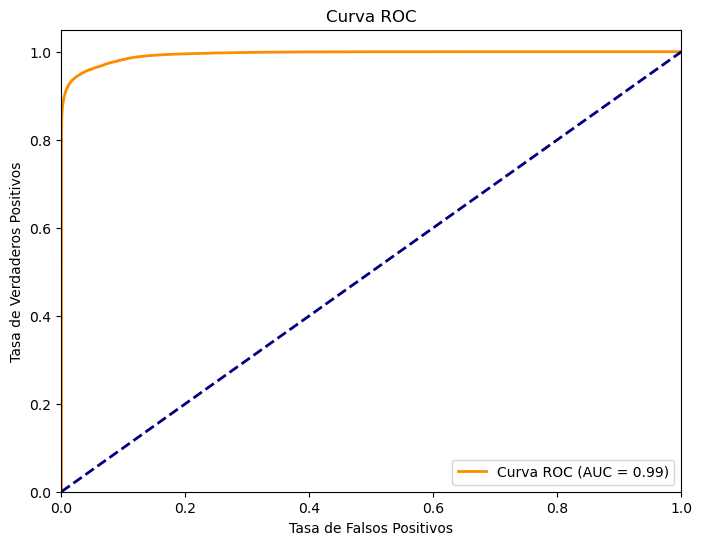

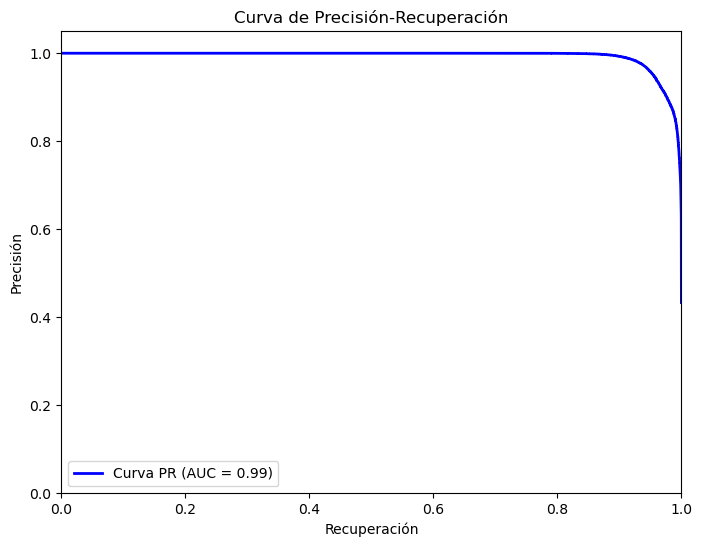

In [21]:
# Obtén las probabilidades de predicción del modelo (ya calculadas durante la validación cruzada)
probs = proba_predictions  # No necesitas llamar a predict_proba

# Crea una lista binaria de etiquetas, 1 para "satisfied" y 0 para "neutral or dissatisfied"
y_true_binary = [1 if label == "satisfied" else 0 for label in y]

# Calcula la curva ROC especificando pos_label=1
fpr, tpr, umbrales_roc = roc_curve(y_true_binary, probs[:, 1], pos_label=1)

# Calcula el área bajo la curva ROC (AUC-ROC)
roc_auc = auc(fpr, tpr)

# Calcula la curva PR
precision, recall, umbrales_pr = precision_recall_curve(y_true_binary, probs[:, 1])

# Calcula el área bajo la curva PR (AUC-PR)
pr_auc = auc(recall, precision)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Graficar la curva PR
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Curva PR (AUC = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recuperación')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recuperación')
plt.legend(loc='lower left')
plt.show()

#### Analisis de curva ROC 

En la curva de ROC podremos notar como el modelo tiene un 0.99 de acertividad a la hora de clasificar, sabiendo distinguir correctamente entre valores correctos e incorrectos con respecto al humbral. La curva de satisfechos y la curva de no satisfechos no se superponen casi en lo absoluto, permitiendo al modelo una facil identificacion y teniendo un minimo error al distinguir entre uno o el otro. 